# Individual Project Planning Stage


In [13]:
library(repr)
library(tidyverse)
library(tidymodels)
options(repr.matrix.max.rows = 10)

# 1. Data Description

# Dataset Overview

- Source: players.csv from UBC Computer Science research group's Minecraft server

- Observations: 200 unique players

- Variables: 7 variables per player

- Collection Method: Data collected from players interacting with a research Minecraft server

# Variable Summary

Variable | Type	| Description | Potential Issues
| --- | --- | --- | --- |
experience | Categorical | Player skill level (Beginner, Amateur, Regular, Veteran, Pro) | N/A
subscribe | Boolean	| Whether player subscribed to newsletter | Binary response variable
hashedEmail | String | Anonymized email identifier | Privacy-protected, not analyzable
played_hours | Numerical | Total hours played | Right-skewed distribution, many zeros
name | String | Player name | Not useful for analysis
gender | Categorical | Gender identity | Multiple categories including small groups
Age | Numerical | Player age | Some missing values (NA)

# Issues Identified:

- Missing age values (2 observations)

- Right-skewed distribution of played_hours

- Potential class imbalance in subscribe variable

- Multiple gender categories with small sample sizes

# 2. Questions

Broad Question: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

Specific Question: Can player experience level, played hours, age, and gender predict newsletter subscription status among Minecraft research server participants?

The data will help address this by allowing me to build a classification model using these player attributes to predict subscription behavior, which can inform targeted recruitment strategies.

# 3. Exploratory Data Analysis and Visualization

In [35]:
# Load the data
players <- read.csv("data/players.csv")
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,TRUE,b6e9e593b9ec51c5e335457341c324c34a2239531e1890b93ca52ac1dc76b08f,0.0,Bailey,Female,17
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57


In [36]:
quantitative_summary <- players |>
  select(played_hours, Age) |>
  summarise(across(everything(), 
                   list(mean = ~mean(., na.rm = TRUE),
                        sd = ~sd(., na.rm = TRUE),
                        min = ~min(., na.rm = TRUE),
                        max = ~max(., na.rm = TRUE)), 
                   .names = "{.col}_{.fn}")) |>
  round(2)
quantitative_summary

played_hours_mean,played_hours_sd,played_hours_min,played_hours_max,Age_mean,Age_sd,Age_min,Age_max
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
5.85,28.36,0,223.1,21.14,7.39,9,58


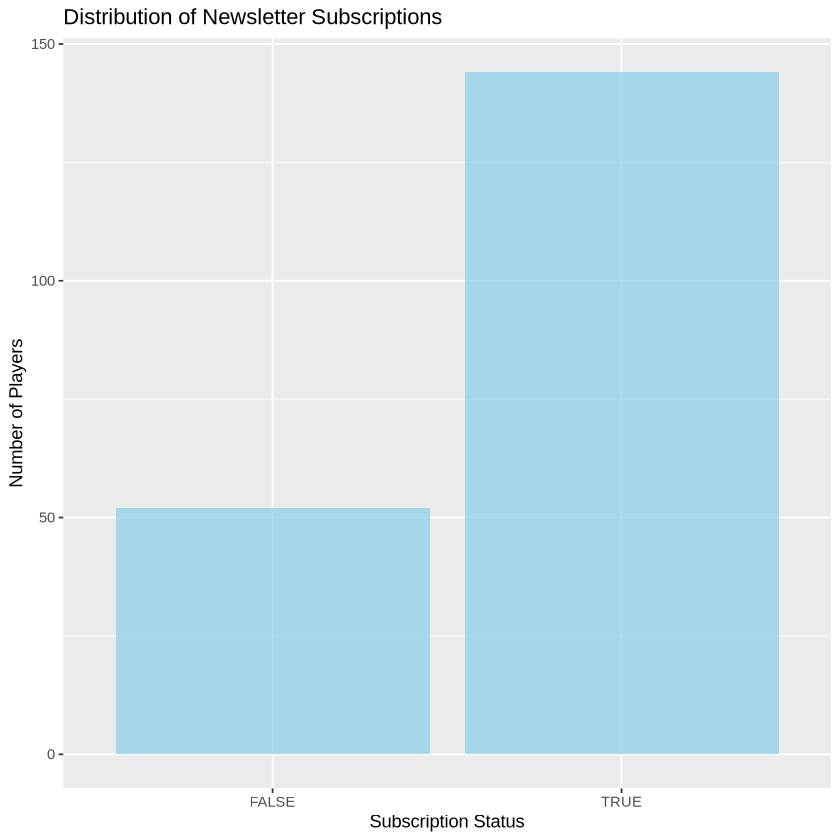

In [37]:
library(ggplot2)
newsletter_subscription <- players |>
  count(subscribe) |>
  ggplot(aes(x = subscribe, y = n)) + 
  geom_bar(stat = "identity", alpha = 0.7, fill = "skyblue") +
  xlab("Subscription Status") +
  ylab("Number of Players") +
  ggtitle("Distribution of Newsletter Subscriptions")
newsletter_subscription

This bar plot reveals a significant class imbalance, with approximately 80% of players subscribing to the newsletter and only 20% declining. This distribution is important for understanding the baseline prediction accuracy, a model that simply predicts "subscribe = TRUE" for all players would already achieve 80% accuracy. The imbalance suggests we need to ensure the minority class (non-subscribers) is properly represented and learned by the predictive model.

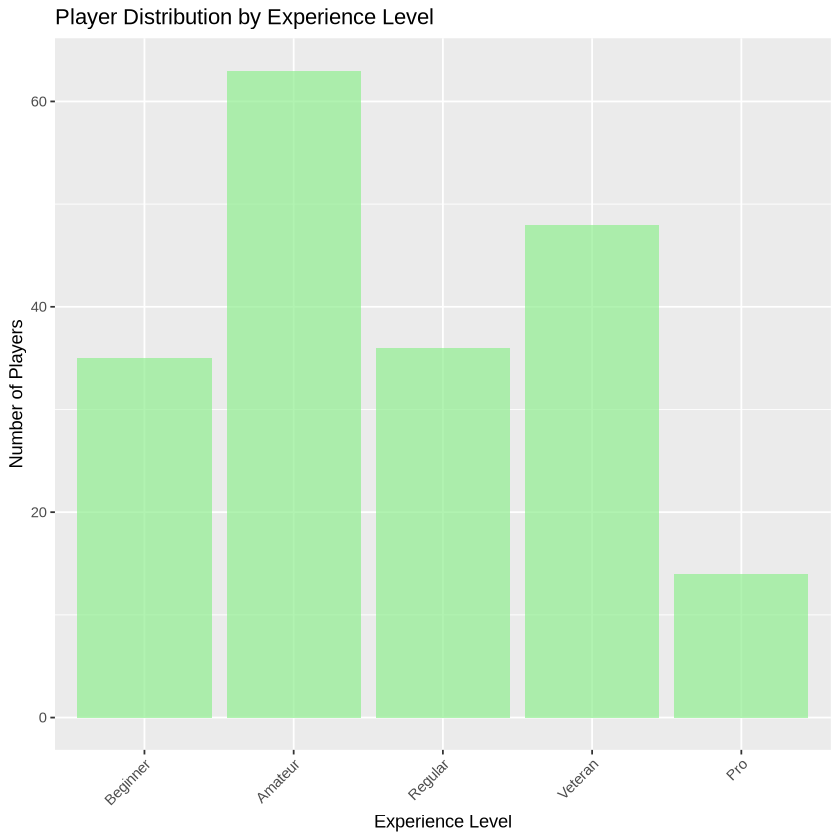

In [38]:
experience_level <- players |>
  count(experience) |>
  mutate(experience = factor(experience, 
                            levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"))) |>
  ggplot(aes(x = experience, y = n)) + 
  geom_bar(stat = "identity", alpha = 0.7, fill = "lightgreen") +
  xlab("Experience Level") +
  ylab("Number of Players") +
  ggtitle("Player Distribution by Experience Level") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
experience_level

The experience level distribution shows that amateur and veteran players are the largest groups, while pro players are the smallest segment. This distribution indicates that our predictive model will have more training data for amateur and veteran players, potentially leading to better predictions for these groups. The ordinal nature of this variable (beginner to pro) should be preserved to capture the progression in player skill levels, which may correlate with subscription behavior.

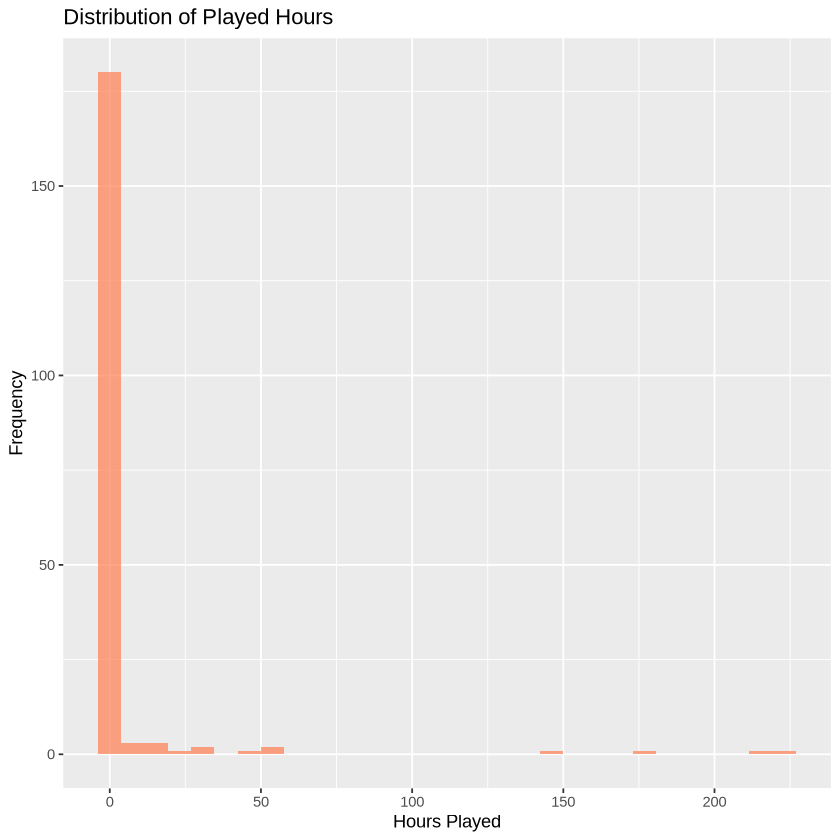

In [39]:
hours_played <- players |>
  ggplot(aes(x = played_hours)) + 
  geom_histogram(alpha = 0.7, fill = "coral", bins = 30) +
  xlab("Hours Played") +
  ylab("Frequency") +
  ggtitle("Distribution of Played Hours")
hours_played

The played hours histogram demonstrates an extreme right-skewed distribution, with most players having very low playtime (under 5 hours) and a small number of players with exceptionally high playtime (over 200 hours). This presents a challenge for linear models and suggests that normalization techniques will be necessary. The presence of many zero-hour players indicates either new users or inactive accounts, which may represent a behavioral pattern relevant to subscription prediction.

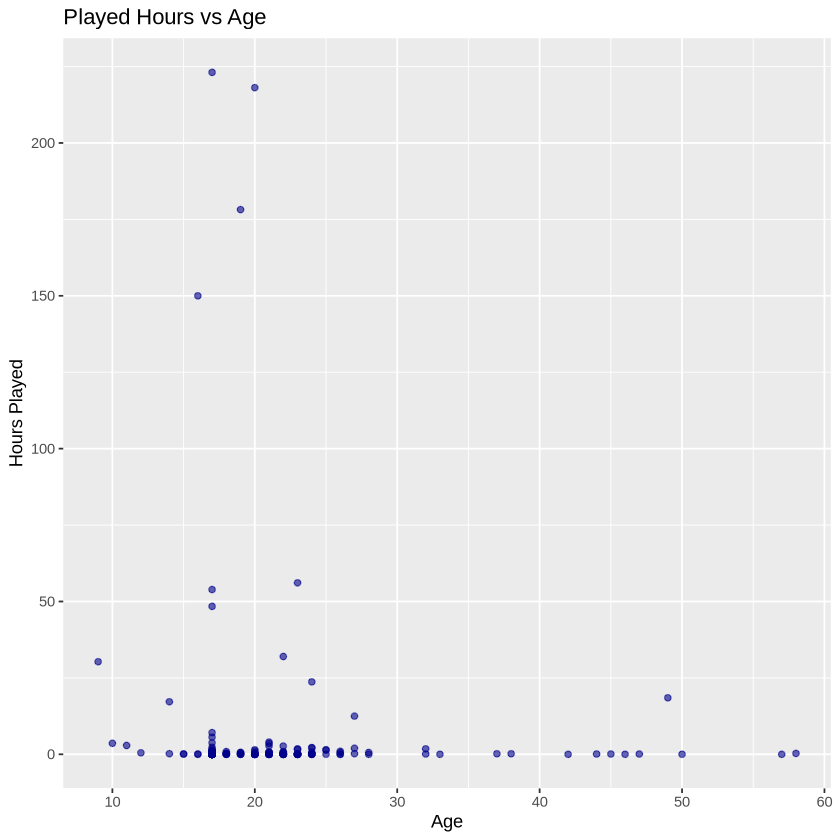

In [40]:
playtime_vs_age <- players |>
  filter(!is.na(Age)) |>
  ggplot(aes(x = Age, y = played_hours)) + 
  geom_point(alpha = 0.6, color = "darkblue") +
  xlab("Age") +
  ylab("Hours Played") +
  ggtitle("Played Hours vs Age")
playtime_vs_age

The scatter plot reveals no clear linear relationship between age and hours played, with players of all ages showing both low and high playtime patterns. The concentration of points in the bottom-left corner (younger ages, low playtime) indicates the dataset contains many young, casual players. The absence of a clear pattern suggests that any relationship between age and playtime is likely complex.

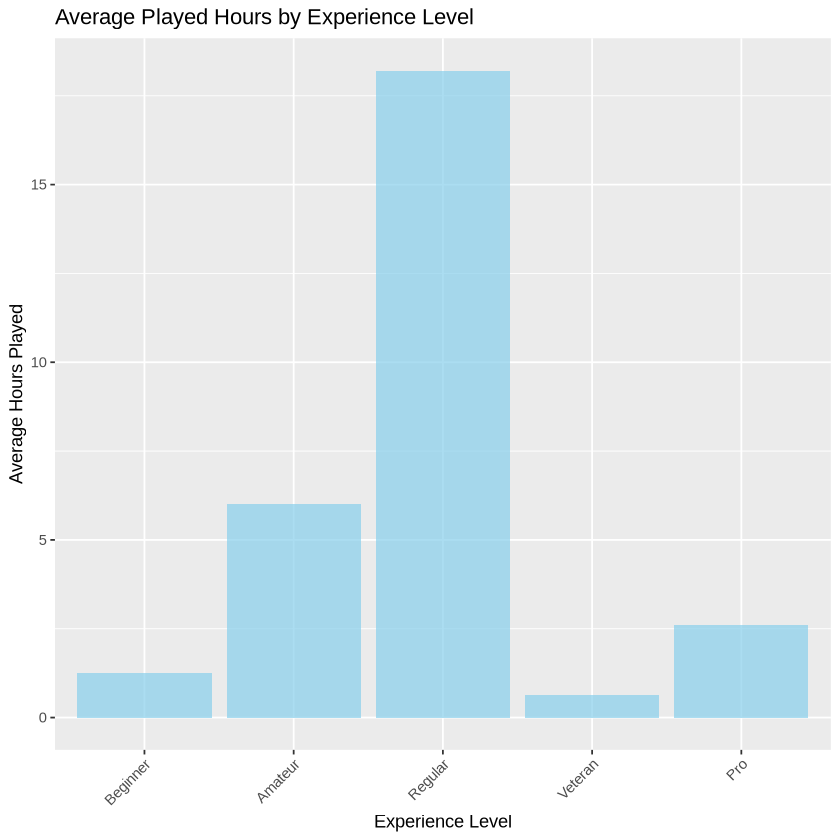

In [41]:
play_time_by_experience <- players |>
  group_by(experience) |>
  summarise(avg_hours = mean(played_hours, na.rm = TRUE)) |>
  mutate(experience = factor(experience, 
                            levels = c("Beginner", "Amateur", "Regular", "Veteran", "Pro"))) |>
  ggplot(aes(x = experience, y = avg_hours)) + 
  geom_bar(stat = "identity", alpha = 0.7, fill = "skyblue") +
  xlab("Experience Level") +
  ylab("Average Hours Played") +
  ggtitle("Average Played Hours by Experience Level") +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))
play_time_by_experience

This bar plot shows a general increasing trend in average playtime from beginner to pro levels, which aligns with the expectation that more experienced players tend to play longer. However, there are still variabilities within each group as shown in the distribution of hours played plot. This pattern suggests that experience level combined with playtime might create meaningful patterns for predicting subscription behavior, such as high-experience, low-playtime players who might represent expired subscribers.

# 4. Methods and Plan

Assumptions:

- Independent observations (reasonable assumption for unique players)

- Adequate sample size for the number of predictors (200 observations)

Potential limitations:

- May not capture complex non-linear relationships between variables

- Sensitive to outliers in the predictor variables

Model comparison and selection:

- Use 5-fold cross-validation on the training set to compare regression with other classification methods (K-Nearest Neighbors)

- Evaluate models using multiple metrics: accuracy, precision, recall

- Select the final model based on cross-validation performance, with particular attention to recall for the minority class (non-subscribers)

Data processing plan:

Preprocessing:

- Handle missing age values using median imputation

- Convert categorical variables (experience, gender)

- Apply standardization to numerical variables (played_hours, Age) using z-score normalization

Data splitting:

- Split data 70%/30% for training and testing sets

- Perform data splitting before any preprocessing

Validation strategy:

- Use 5-fold cross-validation on the training set for model evaluation and selection

- Apply standardization parameters learned from training data to the test set

- Final model evaluation on the completely held-out test set

# 5. GitHub Repository

https://github.com/sophieli-byte/ds_project.git

Word count: 